In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

In [7]:
import cv2 as cv

In [11]:
X = []
Y = []

for i in tqdm(glob('../yawn_dataset/yawn/*')[0:6000]):
    x = cv.imread(i)
    x = cv.cvtColor(x, cv.COLOR_BGR2GRAY)
    x = cv.resize(x, (64,64))
    temp = np.array(x)
    X.append(temp)
    Y.append(1)
    
for i in tqdm(glob('../yawn_dataset/no_yawn/*')[0:6000]):
    x = cv.imread(i)
    x = cv.cvtColor(x, cv.COLOR_RGB2GRAY)
    x = cv.resize(x, (64,64))
    temp = np.array(x)
    X.append(temp)
    Y.append(0)

  0%|          | 0/6000 [00:00<?, ?it/s]

100%|██████████| 6000/6000 [00:00<00:00, 12015.54it/s]


In [12]:
# Pre Processing
X = np.array(X)
X = X/255.0
Y = np.array(Y)

X = np.expand_dims(X,-1)

In [13]:
# test-train split 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

print(y_train.size)
print(y_test.size)

10800
1200


In [14]:
# Model Building 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten

model = tf.keras.models.Sequential([
    Input(shape=(64, 64, 1)),

    Conv2D(filters = 64, kernel_size = 5, strides = 1, activation = 'relu'),
    Conv2D(filters = 64, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
    BatchNormalization(),
    MaxPooling2D(strides = 2),
    Dropout(0.3),

    Conv2D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu'),
    Conv2D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
    BatchNormalization(),
    MaxPooling2D(strides = 2),
    Dropout(0.3),

    Flatten(),
    Dense(units  = 256, activation = 'relu', use_bias=False),
    BatchNormalization(),

    Dense(units = 128, use_bias=False, activation = 'relu'),

    Dense(units = 64, use_bias=False, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(units = 1, activation = 'sigmoid')
])

2023-11-22 01:06:50.873865: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-22 01:06:50.873922: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-22 01:06:50.873927: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-22 01:06:50.874966: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-22 01:06:50.876931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        102400    
                                                                 
 batch_normalization (Batch  (None, 56, 56, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        1

In [16]:
#  Compiling 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='yawn_model_1.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)

In [17]:
# training the model 
model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback)

Epoch 1/30


2023-11-22 01:07:38.217676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


270/270 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.8661

2023-11-22 01:08:21.289463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.26907, saving model to yawn_model_1.h5
270/270 [==============================] - 52s 145ms/step - loss: 0.3113 - accuracy: 0.8661 - val_loss: 1.2691 - val_accuracy: 0.5472
Epoch 2/30
  1/270 [..............................] - ETA: 20s - loss: 0.1411 - accuracy: 0.9688

/Users/umarkhan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


270/270 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9343
Epoch 2: val_loss improved from 1.26907 to 0.16245, saving model to yawn_model_1.h5
270/270 [==============================] - 33s 124ms/step - loss: 0.1737 - accuracy: 0.9343 - val_loss: 0.1624 - val_accuracy: 0.9491
Epoch 3/30
270/270 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9574
Epoch 3: val_loss improved from 0.16245 to 0.10364, saving model to yawn_model_1.h5
270/270 [==============================] - 33s 123ms/step - loss: 0.1173 - accuracy: 0.9574 - val_loss: 0.1036 - val_accuracy: 0.9662
Epoch 4/30
270/270 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9679
Epoch 4: val_loss did not improve from 0.10364
270/270 [==============================] - 33s 123ms/step - loss: 0.0954 - accuracy: 0.9679 - val_loss: 0.1866 - val_accuracy: 0.9273
Epoch 5/30
270/270 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9699
Epoch 5: v

In [18]:
# evaluating the model 
from keras.models import load_model
best_model = load_model('yawn_model_1.h5')
best_model.evaluate(x_test, y_test)

2023-11-22 01:24:59.495977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 6s 91ms/step - loss: 0.0718 - accuracy: 0.9817


[0.07177838683128357, 0.9816666841506958]

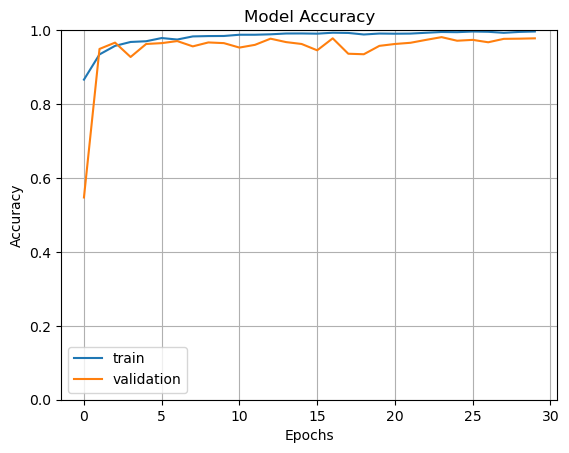

In [19]:
# accuracy 
fig1 = plt.gcf()
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

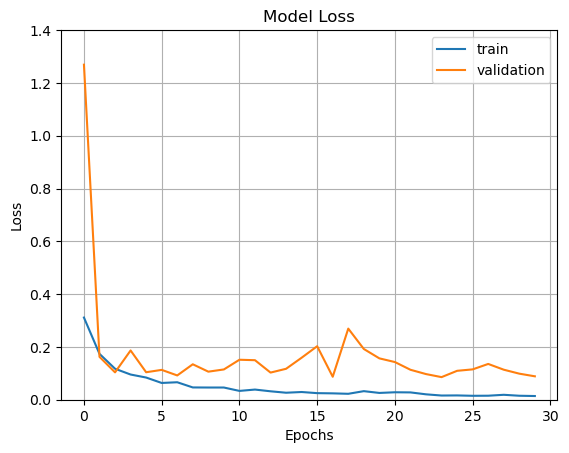

In [20]:
# loss
fig1 = plt.gcf()
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.axis(ymin=0,ymax=1.4)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

38/38 [==============================] - 1s 36ms/step


Text(0.5, 25.722222222222214, 'Actual')

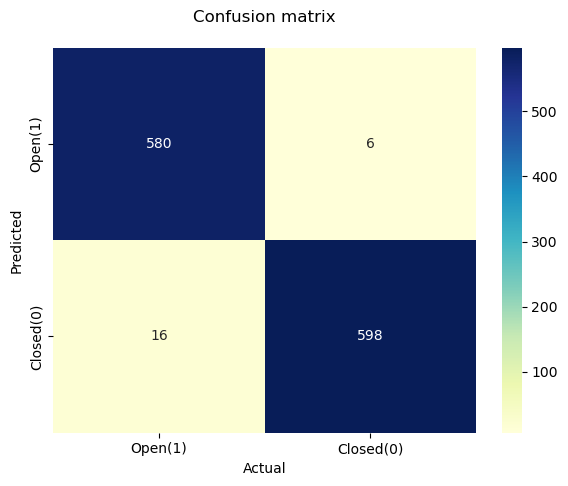

In [24]:
# confusion matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
# print(cm)
df_cm = pd.DataFrame(cm, index=['Open(1)', 'Closed(0)'], columns=['Open(1)', 'Closed(0)'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

In [25]:
# | TP | FP |
# | FN | TN |
tp = cm[0][0]
fn = cm[1][0]
fp = cm[0][1]
tn = cm[1][1]
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy:  0.9816666666666667
Precision:  0.9897610921501706
Recall:  0.9731543624161074
F1 Score:  0.9813874788494078
